In [1]:
library(seewave)
library(signal)
library(pracma)
library(changepoint)


Attaching package: 'signal'


The following object is masked from 'package:seewave':

    unwrap


The following objects are masked from 'package:stats':

    filter, poly



Attaching package: 'pracma'


The following objects are masked from 'package:signal':

    conv, ifft, interp1, pchip, polyval, roots


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Successfully loaded changepoint package version 2.2.2
 NOTE: Predefined penalty values changed in version 2.2.  Previous penalty values with a postfix 1 i.e. SIC1 are now without i.e. SIC and previous penalties without a postfix i.e. SIC are now with a postfix 0 i.e. SIC0. See NEWS and help files for further details.



# 스무딩과 잡음 제거

## 스무딩

- 목적 : 신호에서 원치 않는 스파이크, 추세 및 이상값을 제거하는 과정이 필요하기 때문
- 스무딩 의미 : 잔피크가 많은 신호를 부드럽게 연결해 전반적인 추세만 따라가도록 함
- 스무딩 방법 : 중요한 패턴을 따라가는 함수를 만들어서 주파수 데이터에 fitting
- ex) savgol필터, 이동평균, 이동 중앙값, 선형회귀, 2차회귀 사용

### savgol filter

In [17]:
# savgol(신호데이터, 필터링구간, forder=2)
# 필터링구간은 함수여야함! 보통 51~151사이 구간 쓰는 듯
# forder : 다항함수의 차수

# 정현파생성
ts<-sin(2*pi*(1:1000)/200)
# noise추가
t1<-ts+rnorm(1000)/10

# savgol함수로 스무딩
t2<-savgol(t1, 51)
t3<-savgol(t1, 11)
t4<-savgol(t1, 5)
t5<-savgol(t1, 131)

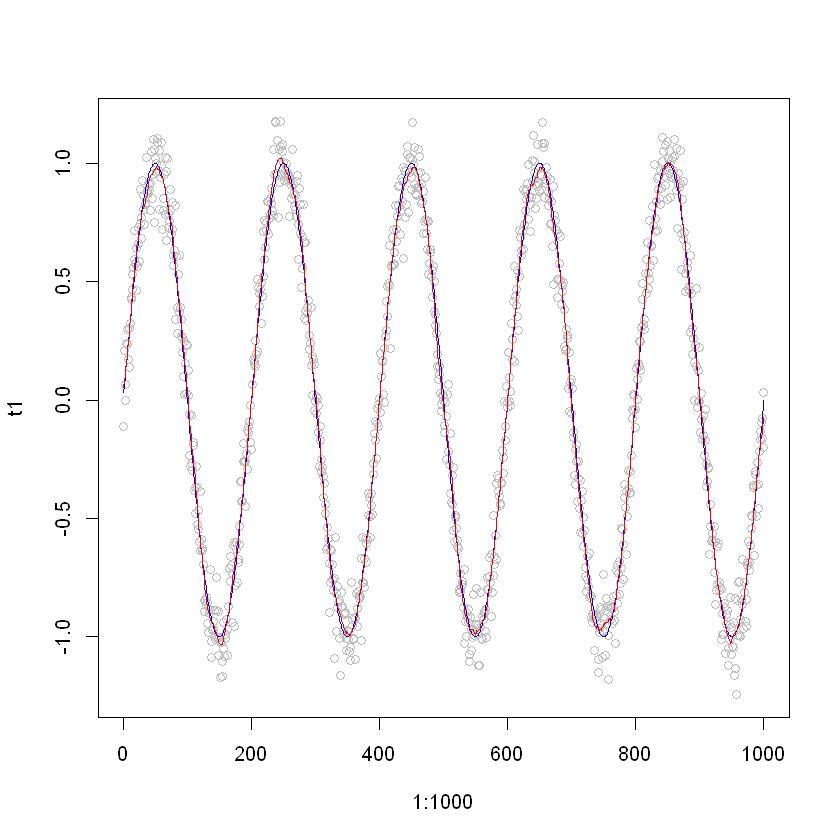

In [16]:
# 정편파+노이즈 추가한 주파수
plot(1:1000,t1,col='grey')
# 노이즈 없던 raw 정현파 나타내기
lines(1:1000,ts, col='blue')
# savgol 필터 거쳐서 스무딩한 주파수 나타내기
# 필터링 구간 51로 설정
lines(1:1000, t2, col='red')



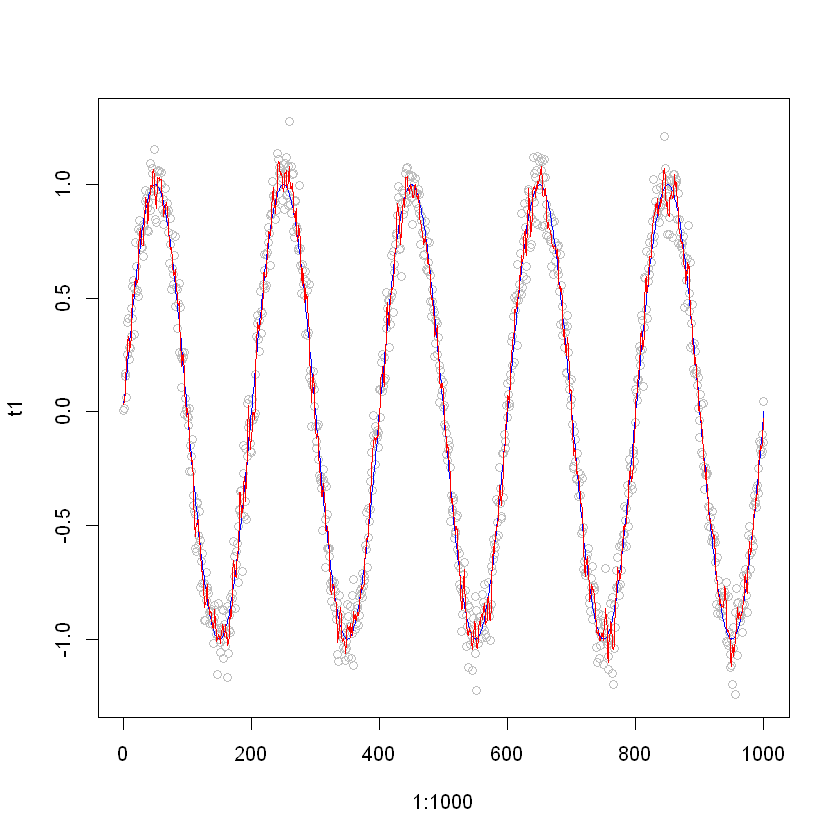

In [18]:
# 정편파+노이즈 추가한 주파수
plot(1:1000,t1,col='grey')
# 노이즈 없던 raw 정현파 나타내기
lines(1:1000,ts, col='blue')
# savgol 필터 거쳐서 스무딩한 주파수 나타내기
# 필터링 구간 11로 설정
lines(1:1000, t3, col='red')


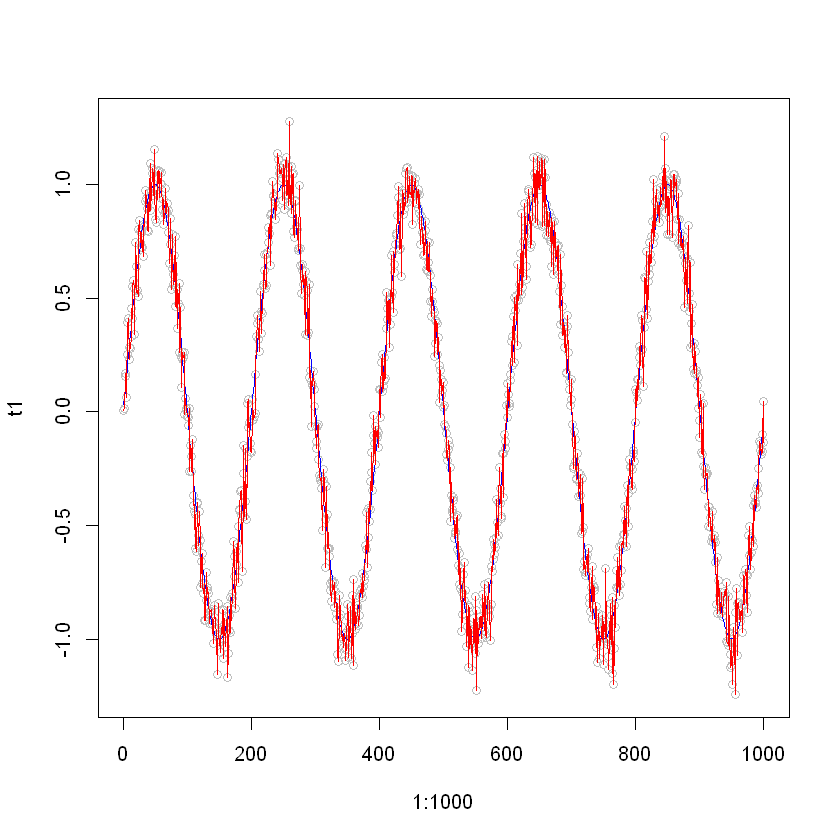

In [19]:
# 정편파+노이즈 추가한 주파수
plot(1:1000,t1,col='grey')
# 노이즈 없던 raw 정현파 나타내기
lines(1:1000,ts, col='blue')
# savgol 필터 거쳐서 스무딩한 주파수 나타내기
# 필터링 구간 1로 설정
lines(1:1000, t4, col='red')


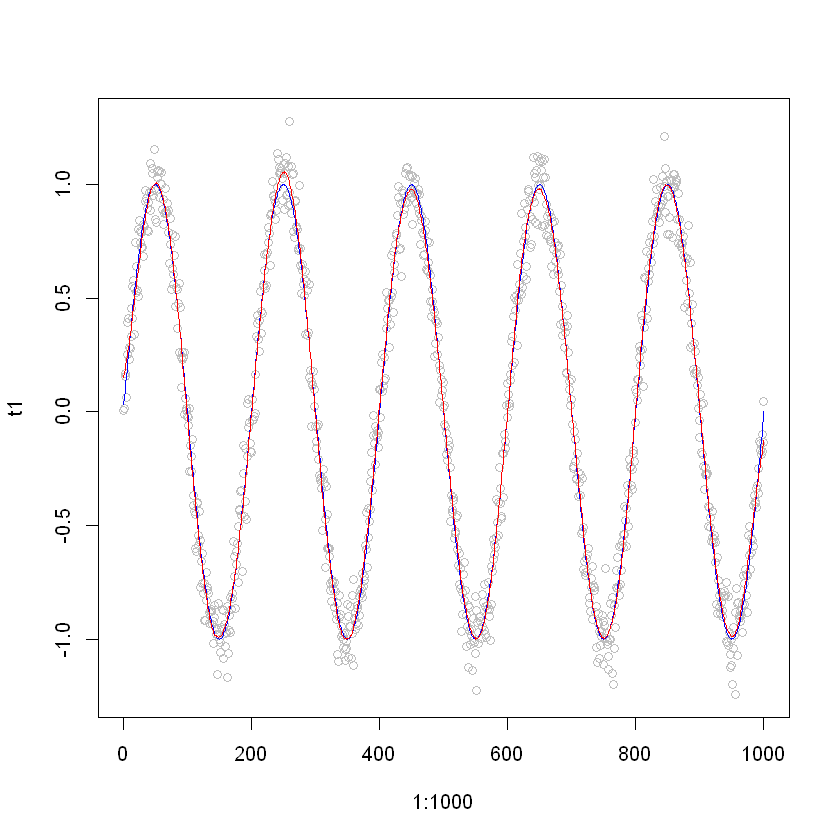

In [20]:
# 정편파+노이즈 추가한 주파수
plot(1:1000,t1,col='grey')
# 노이즈 없던 raw 정현파 나타내기
lines(1:1000,ts, col='blue')
# savgol 필터 거쳐서 스무딩한 주파수 나타내기
# 필터링 구간 131로 설정
lines(1:1000, t5, col='red')


In [29]:
help(savgol)

### median smoothing(이동 중앙값)

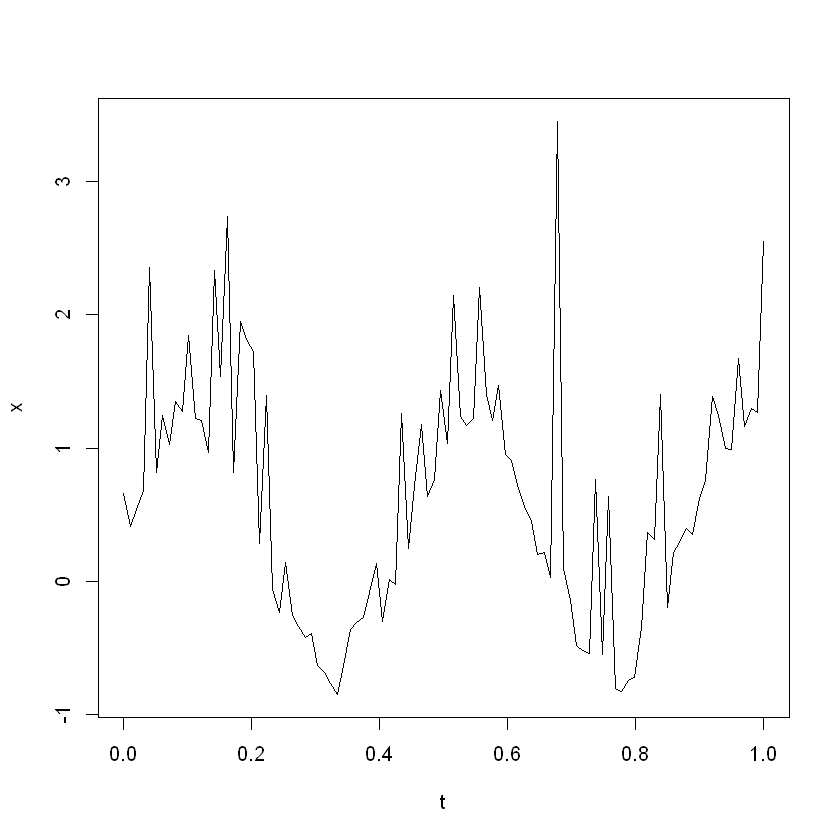

In [23]:
# 변화가 더 심한 신호 생성
t<-seq(0,1, len=100)
# 2.3헤르쯔인 정현파에다가 노이즈 추가 한 신호
x<-sin(2*pi*t*2.3)+0.25*rlnorm(length(t), 0.5)
# t를 x축 x를 y축으로 하는 그래프 그리기
plot(t,x,type='l')

Warning message:
"'medfilt1' is deprecated. Use 'runmed' of the 'stats' package instead."


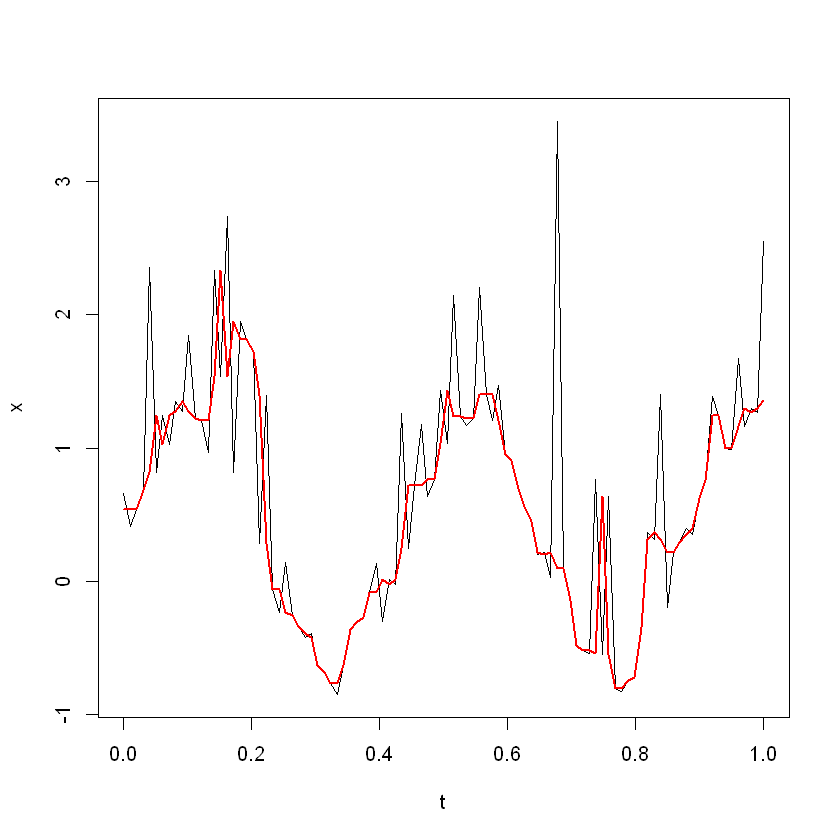

In [24]:
# 3-point filter : 3개의 점의 값을 정렬한 후에 가운데 값을 대표값으로 선택
# medfilt1 함수 사용
plot(t,x,type='l')
lines(t, medfilt1(x), col='red', lwd=2)

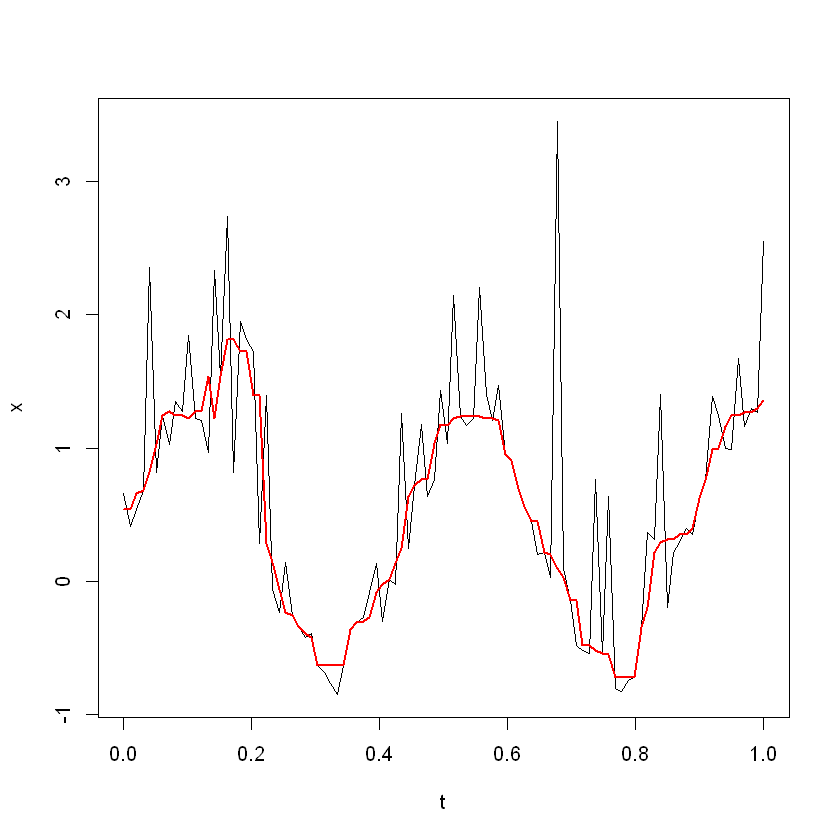

In [25]:
# 7-point filter : 7개의 점의 값을 정렬한 후에 4번째 값을 대표값으로 선택
# filter(MedianFilter(정렬한 점 개수), signal_data) 함수 사용
plot(t,x,type='l')
lines(t, filter(MedianFilter(7), x), col='red', lwd=2)


# 7-point filter 가 더 잔피크를 많이 없애줌!

### ARMA(이동평균 스무딩)

- Arma(b= c(1,2,1)/3, a=c(1,1))
    * a : AR(auto regressive)
    * b : MA(이동평균)
    
- QnA : **``c(1,2,1), c(1,1) 의미가 뭔가유...?``** 

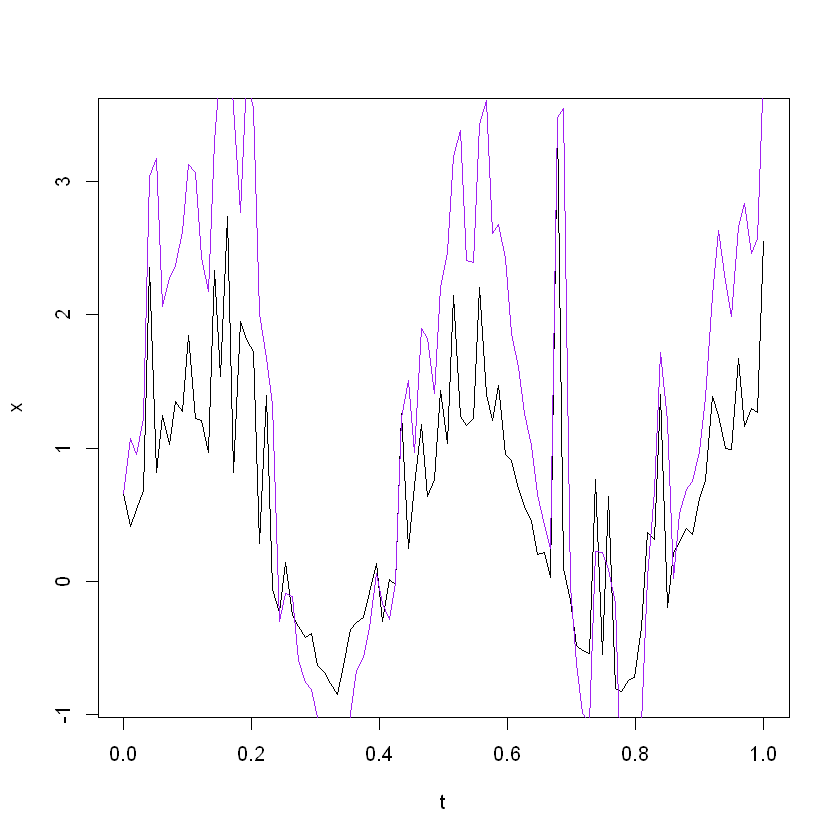

In [28]:
plot(t,x,type='l')
filt<-Arma(b=c(1,2,1), a=c(1,1))
lines(t, filter(filt,x), col='purple')

# QnA : 여기서 쓰인 t,x값이 전에 이동중앙평균값할때 사용했던 t,,x(노이즈추가한 정현파)랑 똑같은 변수 사용하는거 맞나유..?

### 샘플링간격을 달리하여 스무딩

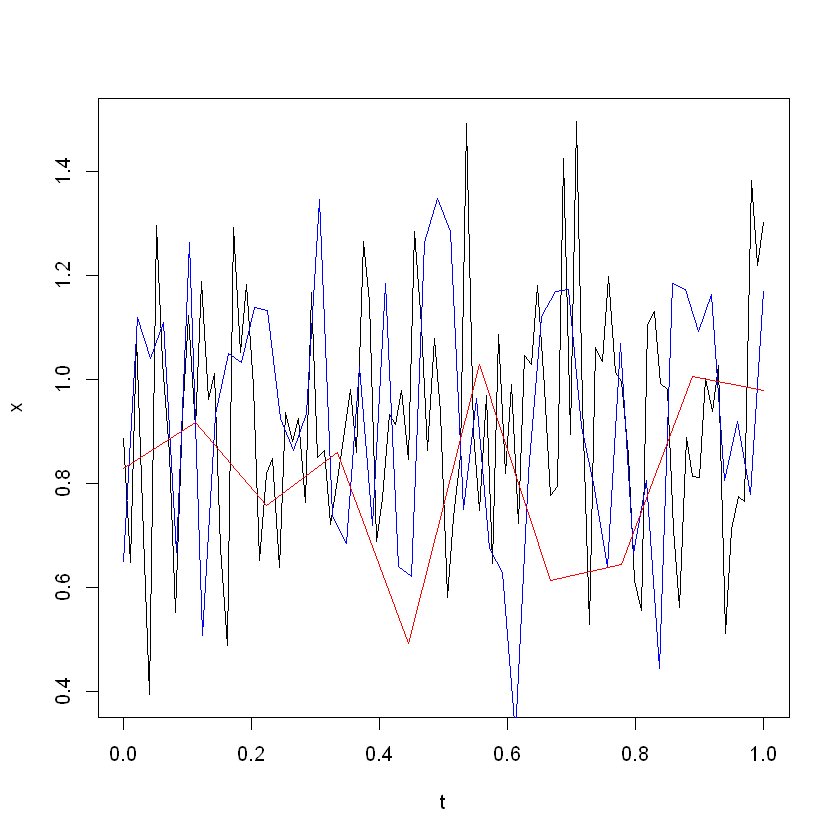

In [35]:
# 기존 샘플링 간격
t<-seq(0,1,len=100)
x<-sin(2*pi*2.3)+0.25*rnorm(length(t))

plot(t,x,type='l')

# 샘플링 간격 10배로 늘려보기 -> len으로 조정
# 간격을 늘렸으므로 신호도 다시 length 조정해줘야함

t1<-seq(0,1, len=50)
x1<-sin(2*pi*2.3)+0.25*rnorm(length(t1))

lines(t1,x1,col='blue')

t2<-seq(0,1, len=10)
x2<-sin(2*pi*2.3)+0.25*rnorm(length(t2))

lines(t2,x2,col='red')


# QnA : 간격을 늘림으로써 잔피크가 많이 스무딩되긴하는데 len=10일때는 너무 다 없애버리는거 아닌가..?;;;

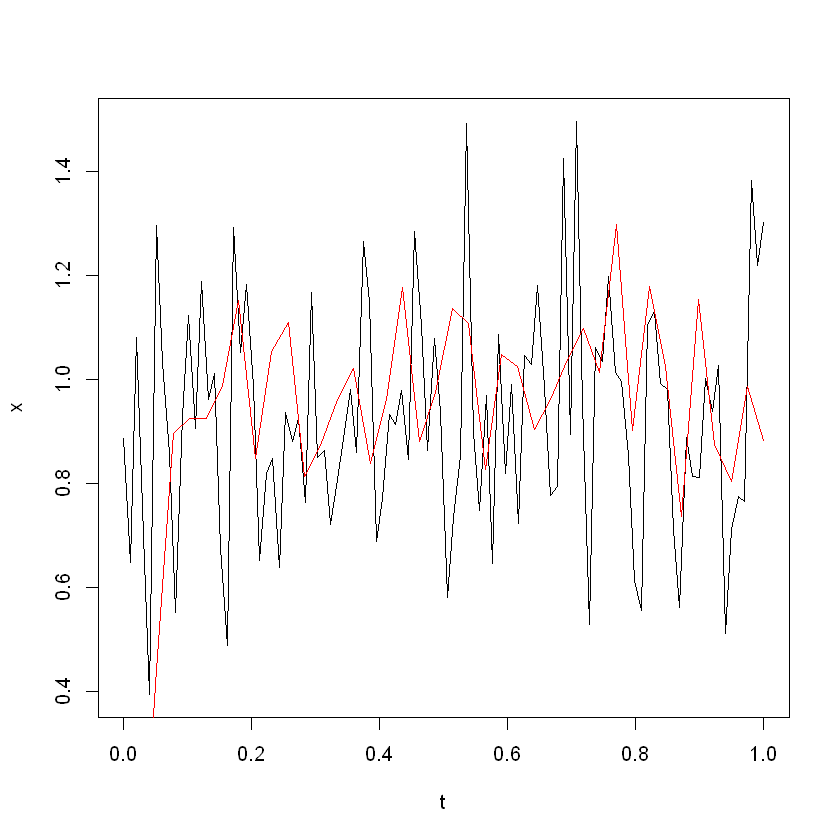

In [36]:
# 위그림처럼 뚝뚝 끊기는 것을 막기위해 resample 함수 사용
# resample(x,4,10) : x라는 신호데이터를 4/10 즉, 40%만 추출해서 사용할 것이다!

plot(t,x,type='l')

#resample사용
re<-resample(x,4,10) 
# resample에 맞춰서 간격 맞춰줘야함! 
lines(seq(0,1,len=40),re, col='red')

## 이상치 제거

- MAD(Median Outlier Deviation) outlier 탐지
- hampel 필터 사용
- hampel(signal_data, k=윈도우구간,t=3)
    * 윈도우구간이 6이라면 실질적 구간은 2x6+1 개 (2k+1)
    * t=3 : 3시그마 벗어나는 값을 이상치로 간주
- hampel 함수 적용 프로세스
    1. 윈도우 구간 설정
    2. 중앙값 지정
    3. 각 포인트마다 중앙값과의 거리(편차)를 구함
    4. 그 편차들을 이용해 표준편차 계산
    5. 중앙값과의 3시그마(위 예시에서) 거리보다 넘어가면 이상치로 간주하고 중앙값으로 대체
    

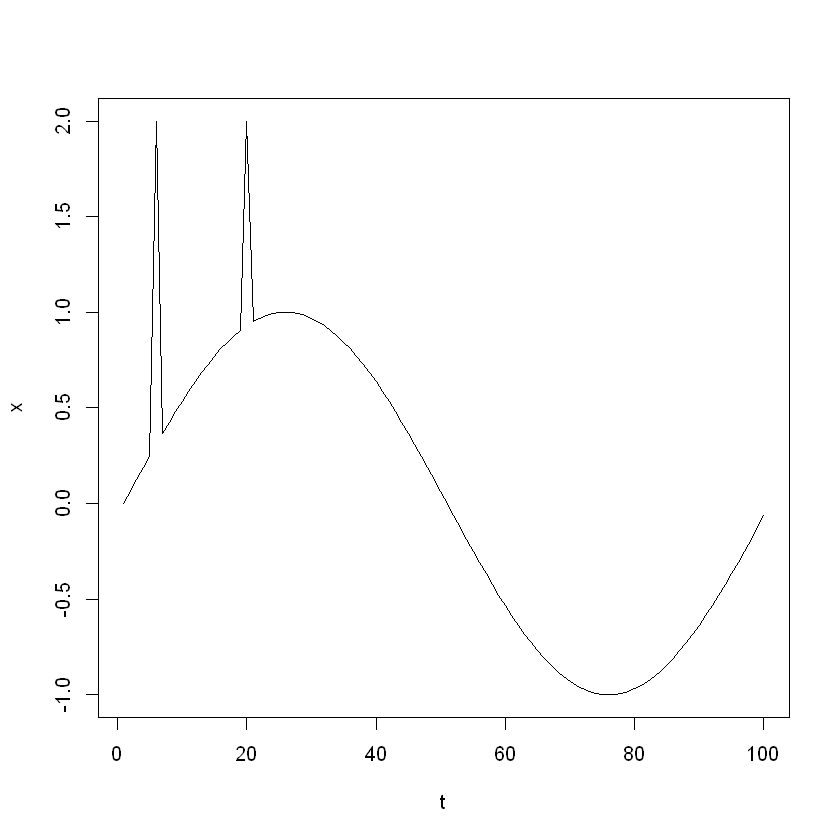

In [43]:
# 신호 생성
x<-sin(2*pi*(0:99)/100)
# 이상치 만들기
x[6]<-2
x[20]<-2

# 생성하고 이상치넣은 신호 시각화
t<-1:length(x)
plot(t,x,'l')

#이상치 값을 제거하는 필터 적용
filter<-hampel(x,k=6,t=2)

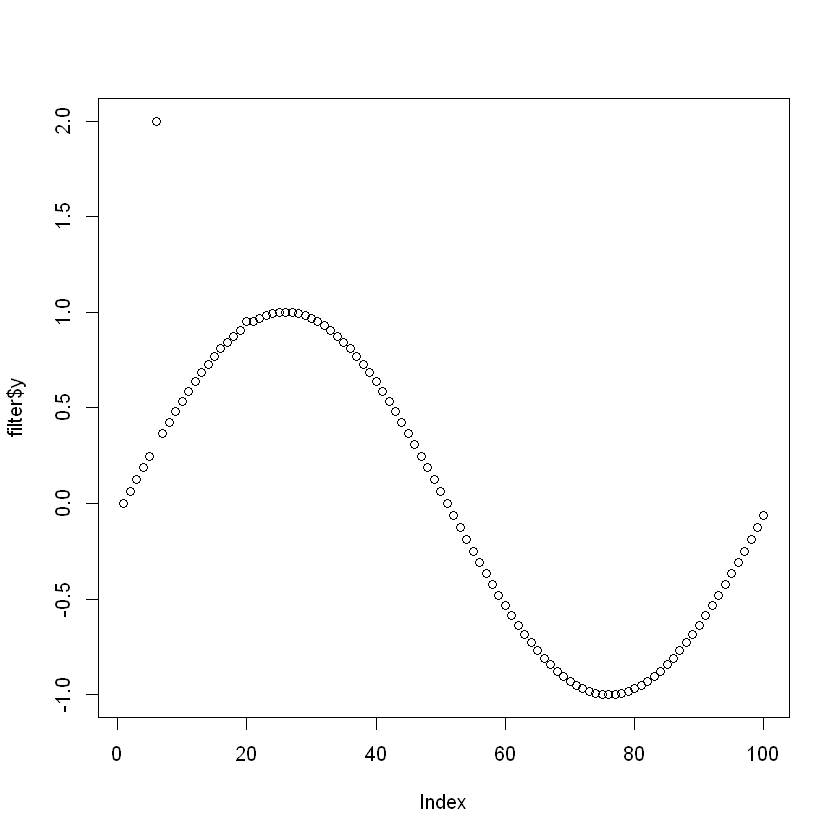

In [45]:
# 이상치 제거한 값들(filter변수의 y변수값) 시각화
plot(filter$y)

## 추세제거

- 주기나 피크 분석시 증가,감소 추세가 있으면 피크 판별이 어렵기 때문에 추세를 제거해줘야 하는 경우 있음
- pracma 패키지의 detrend 함수 사용 -> detrend는 선형 제거하면서 추세 제거함(QnA : 다차원x, 일차원의 추세만 제거 가능..이거 맞나요..?)
- detrend(signal, tt='linear', bp=c())
    * tt : 추세를 어떤함수로 추정할 거인지, 'constant'값이면 상수값(평행선)으로 추정
    * bp : breakpoint의미로 만약 bp=c(4) 이면 전체 구간을 4구간으로 나눔! 
    * ylim : y축의 범위를 나타내줌 
    * QnA : bp=c() 이면 구간을 아예 안나누는건가유?

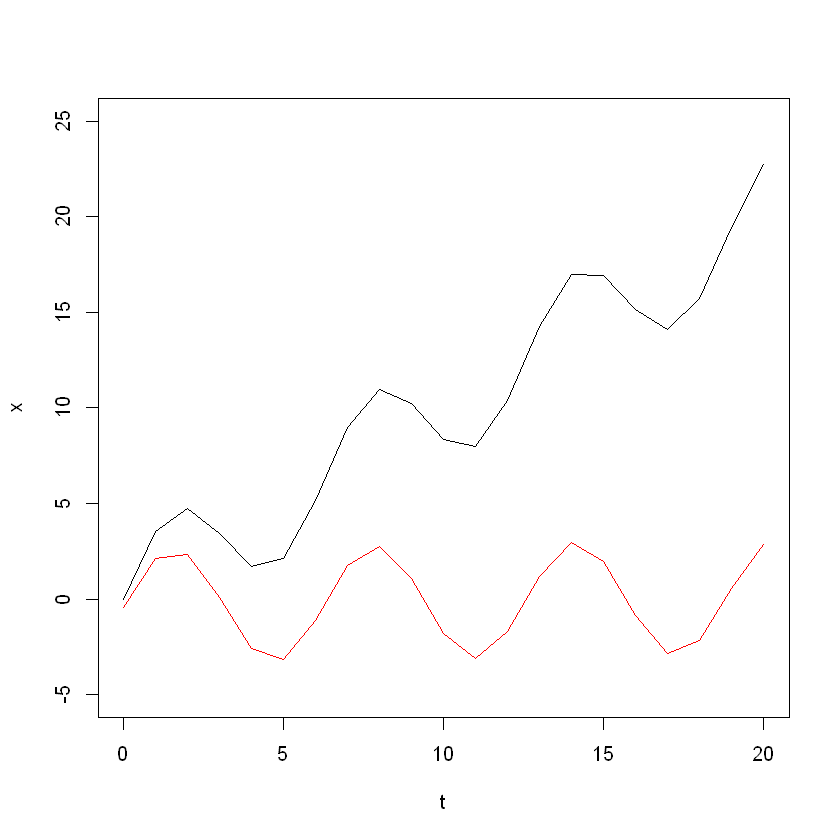

In [47]:
# 신호생성
t<-0:20
x<-3*sin(t)+t
# 추세제거 함수 - linear로 추세를 추정
y<-detrend(x,tt='linear',bp=c())
plot(t,x,'l',ylim=c(-5,25))
lines(t,y,col='red')

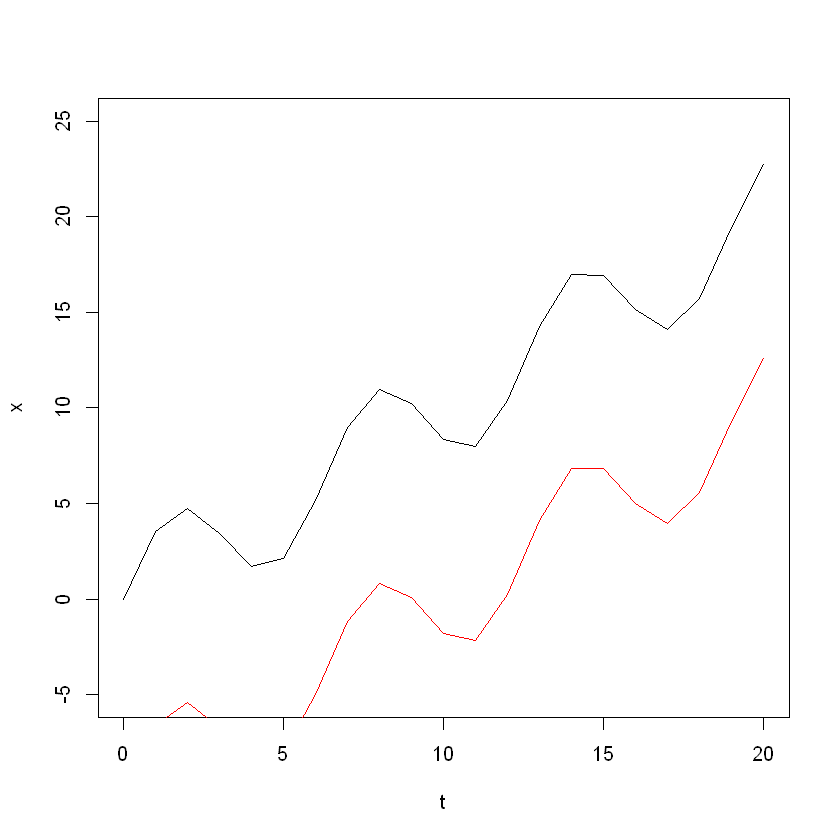

In [48]:
# 신호생성
t<-0:20
x<-3*sin(t)+t
# 추세제거 함수 - 상수값으로 추정
y<-detrend(x,tt='constant',bp=c())
plot(t,x,'l',ylim=c(-5,25))
lines(t,y,col='red')